## **Modelling**
Now, this notebook will be the last step. All remaining part will be applied here. We will try to guess fullness of listings.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error

%matplotlib inline

In [2]:
#exporting the data
calendar_df = pd.read_csv('./calendar.csv')
listings_df = pd.read_csv('./listings.csv')

Our desired outcome is to find a model that forecast two-month density of listings.
Rather than 2-month availability, one-month, three-month and one-year availability data is also existed.
We choose 2-month, most of the density seems to gathered in the first two months, so even one-year or three-month densities is expected not to change results so much.

In [3]:
#We have seen most of appointments have been made for next months, so we will just two-month fullness
listings_df['two_months_density'] = (60-listings_df['availability_60'])/60
listings_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month,two_months_density
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,f,NaN,WASHINGTON,f,moderate,f,f,2,4.07,0.316667
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,f,NaN,WASHINGTON,f,strict,t,t,6,1.48,0.783333
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,f,NaN,WASHINGTON,f,strict,f,f,2,1.15,0.900000
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,f,NaN,WASHINGTON,f,flexible,f,f,1,NaN,1.000000
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,f,NaN,WASHINGTON,f,strict,f,f,1,0.89,0.000000


In [4]:
#we should ensure all the y values exist in dataframe. below code should return 0
listings_df['two_months_density'].isnull().mean()

0.0

### **Forecast Depending on Amenities**
Amenities exists in a column.
Below function will create new columns with the name of given amenities, and they return true or false according to existence of the amenity.
At the second question we determined only the most preferred amenities, so only these amenities will be taken into consideration.
We will try to guess two-month density.

In [5]:
def get_existed_dummies(df, col, look_for):
    '''
    This function is used to used to generate a boolean column according to a list 
    of substring whether exists in a column or not    
    
    INPUT:
    df - the pandas dataframe you want to search
    col - the column name you want to look through
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    
    new_df = defaultdict(int)
    new_df = df.copy()
    #loop through list of ed types
    for val in look_for:
        new_df[val] = ""
        new_df[val] = new_df[col].apply(lambda x: True if val in x else False)
            
    new_df.drop(col, axis=1, inplace=True)
    
    
    return new_df

In [6]:
#we have investigated that some amenities are preferred more by both customers and hosts
#Therefore other columns are ignored
most_preferred_amenitites = ['Internet','Heating',  "Kitchen", 'Smoke Detector','Essentials',  'Washer','TV', 'Shampoo']

In [7]:
#we called the function we just created
services_df = get_existed_dummies(listings_df.copy(), 'amenities', most_preferred_amenitites)
services_df.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,reviews_per_month,two_months_density,Internet,Heating,Kitchen,Smoke Detector,Essentials,Washer,TV,Shampoo
0,241032,https://www.airbnb.com/rooms/241032,20160104002432,2016-01-04,Stylish Queen Anne Apartment,NaN,Make your self at home in this charming one-be...,Make your self at home in this charming one-be...,none,NaN,...,4.07,0.316667,True,True,True,False,False,True,True,False
1,953595,https://www.airbnb.com/rooms/953595,20160104002432,2016-01-04,Bright & Airy Queen Anne Apartment,Chemically sensitive? We've removed the irrita...,"Beautiful, hypoallergenic apartment in an extr...",Chemically sensitive? We've removed the irrita...,none,"Queen Anne is a wonderful, truly functional vi...",...,1.48,0.783333,True,True,True,True,True,True,True,False
2,3308979,https://www.airbnb.com/rooms/3308979,20160104002432,2016-01-04,New Modern House-Amazing water view,New modern house built in 2013. Spectacular s...,"Our house is modern, light and fresh with a wa...",New modern house built in 2013. Spectacular s...,none,Upper Queen Anne is a charming neighborhood fu...,...,1.15,0.900000,True,True,True,True,True,True,True,True
3,7421966,https://www.airbnb.com/rooms/7421966,20160104002432,2016-01-04,Queen Anne Chateau,A charming apartment that sits atop Queen Anne...,NaN,A charming apartment that sits atop Queen Anne...,none,NaN,...,NaN,1.000000,True,True,True,True,True,True,False,True
4,278830,https://www.airbnb.com/rooms/278830,20160104002432,2016-01-04,Charming craftsman 3 bdm house,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,Cozy family craftman house in beautiful neighb...,none,We are in the beautiful neighborhood of Queen ...,...,0.89,0.000000,True,True,True,True,True,False,True,True


A linear regression model will be built.
Two-month density will be tried to be forecasted by looking only amenities.
test size is choosen as 20%.

In [8]:
#here only amenitites taken into consideration
#X and y dataframes are created
X1 = services_df[most_preferred_amenitites]
y1 = services_df['two_months_density']
#splitting
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = .20, random_state=19) 
#a linear model is created with normalization.Then it is trained
lm_model1 = LinearRegression(normalize=True) # Instantiate
lm_model1.fit(X1_train, y1_train) #Fit
#Predict and score the model
y1_test_preds = lm_model1.predict(X1_test)
#score is found according to r squares
case1_score = r2_score(y1_test, y1_test_preds)
case1_train_score = r2_score(y1_train, lm_model1.predict(X1_train))
print(case1_score, case1_train_score)

0.001583109711759234 0.011430497292290065


### **Forecast Depending on Review Scores**
Review score can also be a determining factor.
There 8 columns which show review scores.
Here missing values are assumed as mean of the column.
Since review scores are numbers, we will build the linear regression model easier.

In [9]:
#now we just take into consideration to review scores
review_score_cols = ['review_scores_rating','review_scores_accuracy', 'review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value']

In [10]:

filled_df = pd.concat([(listings_df[review_score_cols].apply(lambda col: col.fillna(col.mean()), axis=0)), listings_df['two_months_density']], axis=1)
filled_df.head()

,review_scores_rating,review_scores_accuracy,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,two_months_density
0,95.000000,10.000000,10.000000,10.000000,10.000000,9.000000,10.000000,0.316667
1,96.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.783333
2,97.000000,10.000000,10.000000,10.000000,10.000000,10.000000,10.000000,0.900000
3,94.539262,9.636392,9.556398,9.786709,9.809599,9.608916,9.452245,1.000000
4,92.000000,9.000000,9.000000,10.000000,10.000000,9.000000,9.000000,0.000000


Again the test size is 20%.
Linear regression model in created.

In [11]:
#here only review scores taken into consideration
#X and y dataframes are created
X2 = filled_df[review_score_cols]
y2 = filled_df['two_months_density']
#splitting
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = .20, random_state=19) 
#a linear model is created with normalization.Then it is trained
lm_model2 = LinearRegression(normalize=True) # Instantiate
lm_model2.fit(X2_train, y2_train) #Fit
#Predict and score the model
y2_test_preds = lm_model2.predict(X2_test)
#score is found according to r squares
case2_score = r2_score(y2_test, y2_test_preds)
case2_train_score = r2_score(y2_train, lm_model2.predict(X2_train))
print(case2_score, case2_train_score)

0.006422174639514111 0.01043594771044154


### **A Mixing Model**
Here both review and amenities will be evaluated.
Test size is same.
Property type is also added here as a determining factor.

In [12]:
#here both reviews and amenities taken into consideration. Property type is also added
#X and y dataframes are created
X3 = pd.concat([filled_df[review_score_cols],services_df[most_preferred_amenitites],pd.get_dummies(listings_df['property_type'])],axis=1)
y3 = filled_df['two_months_density']
X3.head()
#splitting
X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size = .20, random_state=19) 
#a linear model is created with normalization.Then it is trained
lm_model3= LinearRegression(normalize=True) # Instantiate
lm_model3.fit(X3_train, y3_train) #Fit
#Predict and score the model
y3_test_preds = lm_model3.predict(X3_test)
#score is found according to r squares
case3_score = r2_score(y3_test, y3_test_preds)
case3_train_score = r2_score(y3_train, lm_model3.predict(X3_train))
print(case3_score, case3_train_score)

0.0002125414063295361 0.02993589410029618


## Evaluation and Deployment
We get the r2 scores for three different model.
Each model assume a different assumption but none of them seems successfull.
Lets visualize it.

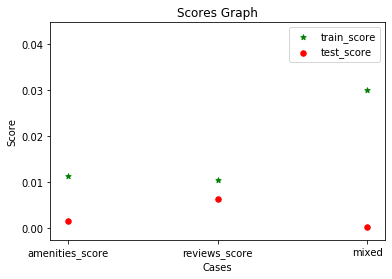

In [13]:
test_scores = [case1_score,case2_score,case3_score]
train_scores = [case1_train_score,case2_train_score,case3_train_score]
labels = ['amenities_score', 'reviews_score', 'mixed']

# plotting points as a scatter plot 
plt.scatter(labels, train_scores, color= "green", marker= "*", s=30) 
plt.scatter(labels, test_scores, color= "red", marker= "o", s=30) 
# x-axis label 
plt.xlabel('Cases') 
# frequency label 
plt.ylabel('Score') 
# plot title 
plt.title('Scores Graph') 
# showing legend 
plt.legend(['train_score', 'test_score']) 

# function to show the plot 
plt.show()


Among three models, review scores tend to be explained with linear regression and get rid of overfitting. But it is still extremely unsatisfying.
As can be seen from the graph, none of the models' test scores even reach the 1%.
We can observe our models' trends with a different a graph.

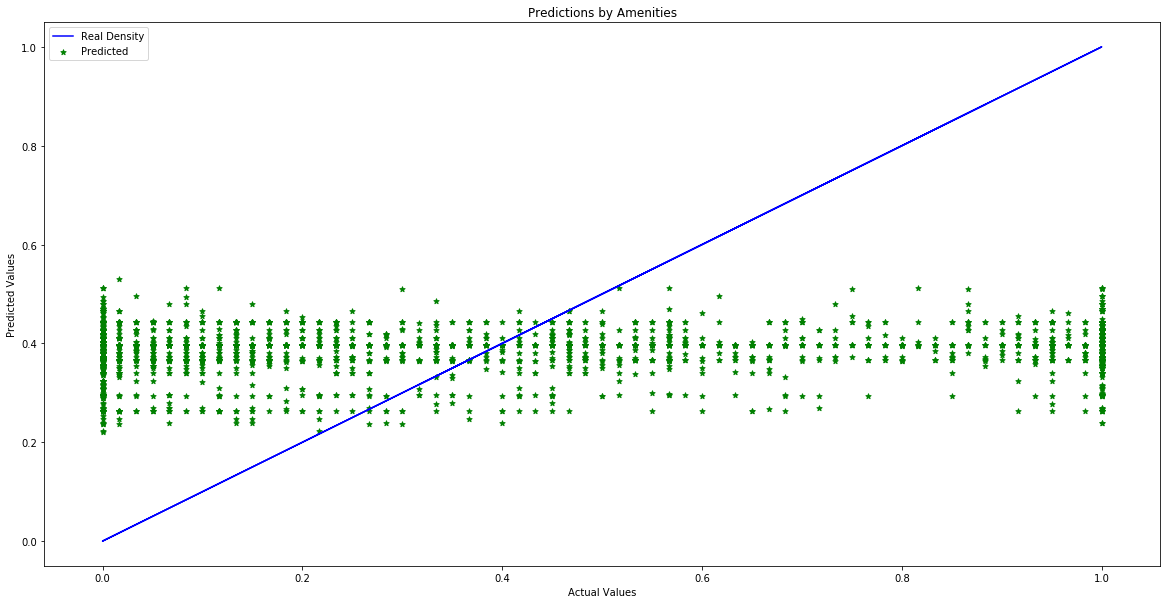

In [14]:
# plotting points as a scatter plot 
fig,ax=plt.subplots()
plt.scatter(y1, lm_model1.predict(X1), color= "green", marker= "*", s=30) 
#plt.scatter(y1, lm_model2.predict(X2), color= "red", marker= "o", s=30)
#plt.scatter(y1, lm_model3.predict(X3), color= "blue", marker= "x", s=30)
ax.plot(y1, y1, color= "blue")
# x-axis label 
plt.xlabel('Actual Values')
# frequency label 
plt.ylabel('Predicted Values')
# plot title 
plt.title('Predictions by Amenities')
# showing legend 
plt.legend(['Real Density', 'Predicted']) 
plt.gcf().set_size_inches(20, 10)
# function to show the plot 
plt.show()

Our models really fail to explain two-month density.
Forecasts are independent from the reality. They look like distributed around 0.4.
We can conclude that these models need to be improved. Even train scores are less than 5%.
New factor can be evaluated like the price.
Linear regression model could not be sufficient to explain these properties.